In [1]:
!pip install gsw

In [2]:
#Download the Falkor and RR data
![[ -e falkor_data.tsv ]] || wget http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/Microbial_Mysteries/bottle_data.flat0? -O falkor_data.tsv
![[ -e rr_data.tsv ]] || wget http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/ETNP_ParticleOmics/bottle.flat0?Cruise=RR1804 -O rr_data.tsv

In [3]:
import pandas as pd
import gsw
import numpy as np

#"Conservative temperature, absolute salinity, oxygen, phosphate, and spiciness were used for this OMPA study"

def process_falkor():
    df = pd.read_csv("falkor_data.tsv", delim_whitespace=True, header=0,
                     na_values=-999)
    df["lat"] = df["LATITUDE"]
    df["lon"] = df["LONGITUDE"]
    df["pressure"] = df["CTDPRS"]
    df["Depth"] = -gsw.z_from_p(p=df["pressure"], lat=df["lat"])
    df["absolute_salinity"] = gsw.SA_from_SP(
                              SP=df["CTDSAL"],
                              p=df["pressure"],
                              lon=df["lon"],
                              lat=df["lat"])
    df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                          t=df["CTDTMP"],
                                          p=df["pressure"])
    df["oxygen"] = df["CTDOXY"]
    df["phosphate"] = np.nan_to_num(df["PHSPHT"], nan=0.0)
    df["spiciness"] = gsw.spiciness0(SA=df["absolute_salinity"],
                                   CT=df["conservative_temp"])
    df["nitrate"] = np.nan_to_num(df["NOx"] - df["NITRIT_BabLab"], nan=0.0) #q: is NOx better to use?
    df["sigma0"] = gsw.rho(SA=df["absolute_salinity"],
                       CT=df["conservative_temp"], p=0) - 1000
    df["mass"] = 1
    return df

def process_rr():
    df = pd.read_csv("rr_data.tsv", delim_whitespace=True, header=0,
                     na_values="nd")
    df["lat"] = df["Latitude"]
    df["lon"] = df["Longitude"]
    df["pressure"] = gsw.p_from_z(z=-df["Depth"], lat=df["lat"])
    df["absolute_salinity"] = gsw.SA_from_SP(
                                  SP=0.5*(df["Sal0"] + df["Sal1"]),
                                  p=df["pressure"],
                                  lon=df["lon"],
                                  lat=df["lat"])
    df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                          t=0.5*(df["T0"] + df["T1"]),
                                          p=df["pressure"])
    df["oxygen"] = 0.5*(df["Sbeox_0"] + df["Sbeox_1"])
    df["phosphate"] = np.nan_to_num(x=df["PO4"], nan=0.0)
    df["spiciness"] = gsw.spiciness0(SA=df["absolute_salinity"],
                                     CT=df["conservative_temp"])
    df["nitrate"] = np.nan_to_num(x=df["NO3"], nan=0.0)
    #(I am not sure why the Sigma_0 column of the original table gives a different
    # answer - rounding errors?)
    df["sigma0"] = gsw.rho(SA=df["absolute_salinity"],
                           CT=df["conservative_temp"], p=0) - 1000
    df["mass"] = 1
    return df

falkor_df = process_falkor()
rr_df = process_rr()


In [5]:
falkor_df.columns

Index(['CRUISEID', 'EXPOCODE', 'STNNBR', 'CASTNO', 'SAMPNO', 'DATE', 'TIME',
       'ISO_DateTime_UTC', 'LATITUDE', 'LONGITUDE', 'BOTTOM_DEPTH', 'CTDPRS',
       'CTDTMP', 'CTDSAL', 'CTDS_FLAG_W', 'CTDOXY', 'CTDOXY_FLAG_W', 'FLOR',
       'FLOR_FLAG_W', 'NOx', 'NOx_FLAG_W', 'NOx_stdev', 'NOx_STD_FLAG_W',
       'NITRIT_BabLab', 'NITRIT_FLAG_W', 'PHSPHT', 'PHSPHT_FLAG_W', 'NH4',
       'NH4_FLAG_W', 'PH_TOT', 'PH_TOT_FLAG_W', 'PH_TEMP', 'TA', 'TA_FLAG_W',
       'lat', 'lon', 'pressure', 'Depth', 'absolute_salinity',
       'conservative_temp', 'oxygen', 'phosphate', 'spiciness', 'nitrate',
       'sigma0', 'mass'],
      dtype='object')

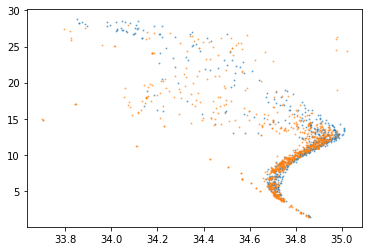

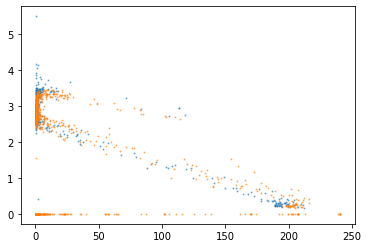

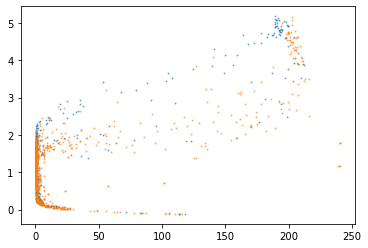

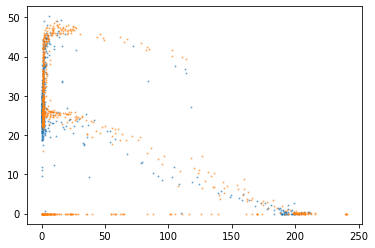

In [6]:
#sanity check by replotting some figures from Fig 3
from matplotlib import pyplot as plt

plt.scatter(falkor_df["absolute_salinity"],
            falkor_df["conservative_temp"], s=1, alpha=0.5)
plt.scatter(rr_df["absolute_salinity"],
            rr_df["conservative_temp"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["phosphate"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["phosphate"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["spiciness"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["spiciness"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["nitrate"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["nitrate"], s=1, alpha=0.5)
plt.show()

In [7]:
def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name",
                               "conservative_temp", "absolute_salinity",
                               "oxygen", "phosphate", "spiciness"])
    df["mass"] = 1
    return df

#From table 1 in the text
                                   #Temp  Sal    Oxy     Phos     Spic
TSW_FK =         ["TSW_FK",        26.95, 34.06, 192.70, 0.223,  4.970]
ESW_FK =         ["ESW_FK",        23.28, 34.56, 212.00, 0.170,  3.800]
PSUW_proxy_FK =  ["PSUW_proxy_FK", 15.93, 34.13, 188.40, 0.437,  1.790]
CW13_FK =        ["13CW_FK",       12.54, 34.98,   0.59, 2.730,  1.580]
NEPIW_FK =       ["NEPIW_FK",       9.56, 34.80,   0.64, 3.100,  0.894]

TSW_RR =         ["TSW_RR",        26.56, 33.83, 192.70, 0.223,  4.360]
ESW_RR =         ["ESW_RR",        21.26, 34.44, 212.00, 0.170,  3.300]
PSUW_proxy_RR =  ["PSUW_proxy_RR", 16.71, 34.13, 188.40, 0.437,  1.910]
CW13_RR =        ["13CW_RR",       13.08, 34.95,   0.69, 2.730,  1.680]
NEPIW_RR =       ["NEPIW_RR",       9.56, 34.80,   0.90, 3.100,  0.894]

AAIW =           ["AAIW",           6.03, 34.70,   4.80, 3.480,  0.418]
UCDW_proxy =     ["UCDW_proxy",     1.42, 34.87, 118.00, 2.670, -0.110]


surfacewaters_FK_endmemberdf = prepare_endmember_df([
                    TSW_FK, ESW_FK, PSUW_proxy_FK,
                    CW13_FK#, NEPIW_FK, AAIW, UCDW_proxy
])

intermediatewaters_FK_endmemberdf = prepare_endmember_df([
                    #TSW_FK, ESW_FK, PSUW_proxy_FK,
                    CW13_FK, NEPIW_FK, AAIW#, UCDW_proxy
])

intermediatewaters_RR_endmemberdf = prepare_endmember_df([
                    #TSW_RR, ESW_RR, PSUW_proxy_RR,
                    CW13_RR, NEPIW_RR, AAIW#, UCDW_proxy
])

intermediatewaters_FK_endmemberdf_withpsuw = prepare_endmember_df([
                    #TSW_FK, ESW_FK,
                    PSUW_proxy_FK,
                    CW13_FK, NEPIW_FK, AAIW#, UCDW_proxy
])

intermediatewaters_RR_endmemberdf_withpsuw = prepare_endmember_df([
                    #TSW_RR, ESW_RR,
                    PSUW_proxy_RR,
                    CW13_RR, NEPIW_RR, AAIW#, UCDW_proxy
])

In [8]:
import altair as alt

properties = ["absolute_salinity", "conservative_temp", "oxygen", "phosphate", "nitrate"]

def nozero_xaxis(field_name):                                                   
    return alt.X(field_name, scale=alt.Scale(zero=False))                         
                                                                                
                                                                                
def nozero_yaxis(field_name, domain=None):                                      
    if (domain is None):                                                          
        return alt.Y(field_name, scale=alt.Scale(zero=False))                       
    else:                                                                         
        return alt.Y(field_name, scale=alt.Scale(zero=False, domain=domain))

def make_interactive_pp(altairdf):
    
    interval_selection = alt.selection_interval()
    obs_basechart = alt.Chart(altairdf).mark_point().encode(                    
      tooltip=properties,                                                  
      color=alt.condition(interval_selection,                                   
                          alt.value("lightblue"),#"NPIW",                       
                          alt.value('lightgray'))                               
      ).add_selection(interval_selection).properties(                           
          width=300,                                                    
          height=300)
    the_pp_scatterplots = []                                                    
    for i in range(len(properties)):                                           
        for j in range(i+1,len(properties)):
            color = alt.condition(interval_selection, alt.value('lightblue'),                    
                                  alt.value('lightgray'))
            the_pp_scatterplots.append(                                         
                obs_basechart.mark_point().encode(                   
                    nozero_xaxis(properties[i]),                                        
                    nozero_yaxis(properties[j]),                                        
                    color=color)                                              
            )
    return alt.vconcat(*the_pp_scatterplots)

make_interactive_pp(falkor_df)

alt.VConcatChart(...)

Falkor nitrate


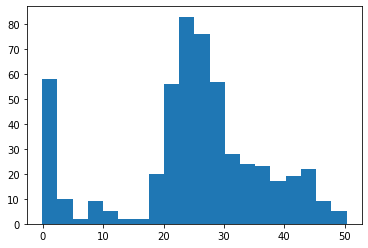

rr nitrate


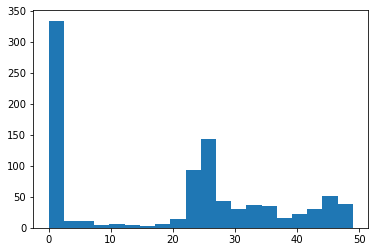

13CW_FK


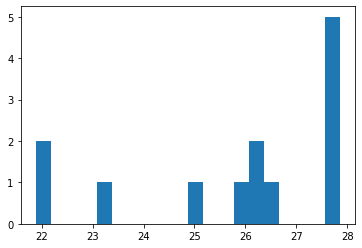

NEPIW_FK


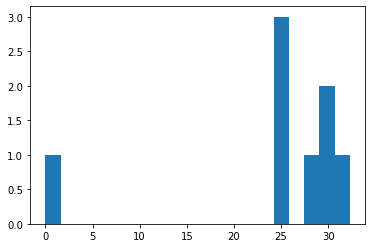

AAIW


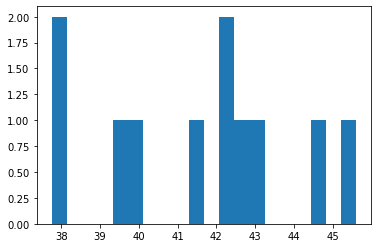

In [9]:
print("Falkor nitrate")
plt.hist(falkor_df["nitrate"], bins=20)
plt.show()
print("rr nitrate")
plt.hist(rr_df["nitrate"], bins=20)
plt.show()

def get_nitrate_val_for_endmember(emrow, obsdf):
    print(emrow[0])
    temp = emrow[1]
    sal = emrow[2]
    temp_filter = ( (obsdf["conservative_temp"] <= (temp+0.2))
                   & (obsdf["conservative_temp"] >= (temp-0.2)) )
    sal_filter = ( (obsdf["absolute_salinity"] <= (sal+0.02))
                   & (obsdf["absolute_salinity"] >= (sal-0.02)))
    plt.hist(obsdf[temp_filter & sal_filter]["nitrate"], bins=20)
    plt.show()

get_nitrate_val_for_endmember(emrow=CW13_FK, obsdf=falkor_df)
get_nitrate_val_for_endmember(emrow=NEPIW_FK, obsdf=falkor_df)
get_nitrate_val_for_endmember(emrow=AAIW, obsdf=falkor_df)

In [10]:
np.sum(falkor_df["spiciness"] < 0)

6

In [14]:
%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

surfacewaters_falkordf = pd.DataFrame(falkor_df[(falkor_df["sigma0"] < 26.0)])
intermediatewaters_falkordf = pd.DataFrame(falkor_df[(falkor_df["sigma0"] >= 26.0)
                                                     & (falkor_df["sigma0"] <= 27.0)])
intermediatewaters_rrdf = pd.DataFrame(rr_df[(rr_df["sigma0"] >= 26.0)
                                             & (rr_df["sigma0"] <= 27.0)])

conversionratios_orig = {
    "oxygen": [-1],
    "phosphate": [1.0/170], #170 is the default redfield ratio in matlab OMPA, I also recall seeing it somewhere
}

evansorig_convertedparamgroups = [
    pyompa.ConvertedParamGroup(groupname="phosphate_remin",
                               conversion_ratios=[{"oxygen": -170, "phosphate": 1.0}],
                               always_positive=True)
]

evansorig_convertedparamgroups_assimpossible = [
    pyompa.ConvertedParamGroup(groupname="phosphate_remin",
                               conversion_ratios=[{"oxygen": -170, "phosphate": 1.0}],
                               always_positive=False)
]

evansorig_paramweightings = {
    "conservative_temp": 24.0,
    "absolute_salinity": 24.0,
    "spiciness": 7.0,
    "mass": 24.0,
    "oxygen": 7.0,
    "phosphate": 2.0
}

evansorig_settings = {
    "param_names": ["conservative_temp", "absolute_salinity", "spiciness", "oxygen", "phosphate", "mass"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    "sumtooneconstraint": False,
    "standardize_by_watertypes": True
}

evansorig_settings_nospiciness = {
    "param_names": ["conservative_temp", "absolute_salinity", "oxygen", "phosphate", "mass"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    "sumtooneconstraint": False,
    "standardize_by_watertypes": True
}

evansorig_settings_nospiciness_hardmassconstraint = {
    "param_names": ["conservative_temp", "absolute_salinity", "oxygen", "phosphate"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    "sumtooneconstraint": True,
    "standardize_by_watertypes": True
}

evansorig_settings_nospiciness_hardmassconstraint_assimpossible = {
    "param_names": ["conservative_temp", "absolute_salinity", "oxygen", "phosphate"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups_assimpossible,
    "sumtooneconstraint": True,
    "standardize_by_watertypes": False
}

settingname_to_surfaceompasoln = {}
settingname_to_fkintermediatesoln = {}
settingname_to_rrintermediatesoln = {}

for settingname,settings in [("evansorig_settings", evansorig_settings),
                             ("evansorig_settings_nospiciness", evansorig_settings_nospiciness),
                             ("evansorig_settings_nospiciness_hardmassconstraint",
                              evansorig_settings_nospiciness_hardmassconstraint),
                             ("evansorig_settings_nospiciness_hardmassconstraint_assimpossible",
                              evansorig_settings_nospiciness_hardmassconstraint_assimpossible)
                            ]:
    settingname_to_surfaceompasoln[settingname] = pyompa.OMPAProblem(
                          obs_df = surfacewaters_falkordf,
                          **settings).solve(
                              surfacewaters_FK_endmemberdf,
                              endmember_name_column="endmember_name")

    settingname_to_fkintermediatesoln[settingname] = pyompa.OMPAProblem(
          obs_df = intermediatewaters_falkordf,
          **settings).solve(intermediatewaters_FK_endmemberdf,
                            endmember_name_column="endmember_name")
    
    settingname_to_rrintermediatesoln[settingname] = pyompa.OMPAProblem(
          obs_df = intermediatewaters_rrdf,
          **settings).solve(intermediatewaters_RR_endmemberdf,
                            endmember_name_column="endmember_name")
    
settingname_to_fkintermediatesoln_withpsuw = {}
settingname_to_rrintermediatesoln_withpsuw = {}
for settingname,settings in [("evansorig_settings_nospiciness_hardmassconstraint_withpsuw",
                              evansorig_settings_nospiciness_hardmassconstraint)]:
    settingname_to_fkintermediatesoln_withpsuw[settingname] = pyompa.OMPAProblem(
          obs_df = intermediatewaters_falkordf,
          **settings).solve(intermediatewaters_FK_endmemberdf_withpsuw,
                            endmember_name_column="endmember_name")
    
    settingname_to_rrintermediatesoln_withpsuw[settingname] = pyompa.OMPAProblem(
          obs_df = intermediatewaters_rrdf,
          **settings).solve(intermediatewaters_RR_endmemberdf_withpsuw,
                            endmember_name_column="endmember_name")

I'm assuming that the index encoding mass is: [5]
Std used for normalization: [ 6.60441519  0.426722    1.63263591 99.08791395  1.23208468  1.        ]
Mean used for normalization: [ 19.675   34.4325   3.035  148.4225   0.89     0.    ]
params to use: ['conservative_temp', 'absolute_salinity', 'spiciness', 'oxygen', 'phosphate', 'mass']
param weighting: [24. 24.  7.  7.  2. 24.]
effective weighting: [5.50227771e-01 1.31801748e+02 2.62614894e+00 7.12946053e-04
 1.31749470e+00 2.40000000e+01]
Conversion ratios:
OrderedDict([('phosphate_remin', defaultdict(<class 'list'>, {'oxygen': [-170], 'phosphate': [1.0]}))])
Matrix A:
Trying convertedvariable sign constraint: [1]
status: optimal
optimal value 1002.8505207100627
Original weighted sum squares: 1002.8505207100641
Post fix weighted sum squared: 1002.8505207100654
status: optimal
optimal value 1002.8505207100627
Original weighted sum squares: 1002.8505207100641
Post fix weighted sum squared: 1002.8505207100654
objective: 1002.85052071006

status: optimal
optimal value 170523.26497960568
Original weighted sum squares: 170523.26498216362
Post fix weighted sum squared: 170523.26498721555
status: optimal
optimal value 170523.26497960568
Original weighted sum squares: 170523.26498216362
Post fix weighted sum squared: 170523.26498721555
objective: 170523.26498721552
params to use: ['conservative_temp', 'absolute_salinity', 'oxygen', 'phosphate']
param weighting: [24. 24.  7.  2.]
Conversion ratios:
OrderedDict([('phosphate_remin', defaultdict(<class 'list'>, {'oxygen': [-170], 'phosphate': [1.0]}))])
Matrix A:
Trying convertedvariable sign constraint: [1]
status: optimal
optimal value 24442.04848952266
Original weighted sum squares: 24442.048529360774
Post fix weighted sum squared: 24442.048770340498
Trying convertedvariable sign constraint: [-1]
status: optimal
optimal value 292409.2384725547
Original weighted sum squares: 292409.238473837
Post fix weighted sum squared: 292409.2384817012
status: optimal
optimal value 18540.5

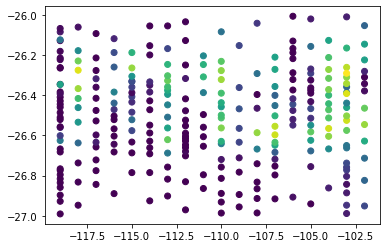

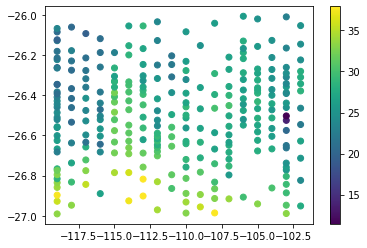

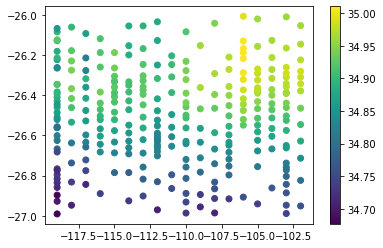

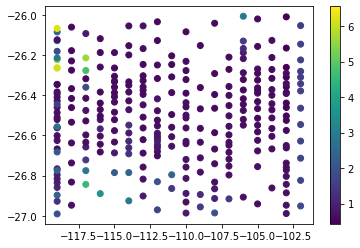

In [15]:
plt.scatter(
    intermediatewaters_falkordf["lon"],
    -intermediatewaters_falkordf["sigma0"],
    c=intermediatewaters_falkordf["NITRIT_BabLab"]
)
plt.show()

plt.scatter(
    intermediatewaters_falkordf["lon"],
    -intermediatewaters_falkordf["sigma0"],
    c=intermediatewaters_falkordf["NOx"]
)
plt.colorbar()
plt.show()

plt.scatter(
    intermediatewaters_falkordf["lon"],
    -intermediatewaters_falkordf["sigma0"],
    c=intermediatewaters_falkordf["absolute_salinity"]
)
plt.colorbar()
plt.show()

plt.scatter(
    intermediatewaters_falkordf["lon"],
    -intermediatewaters_falkordf["sigma0"],
    c=intermediatewaters_falkordf["oxygen"]
)
plt.colorbar()
plt.show()



Falkor
evansorig_settings


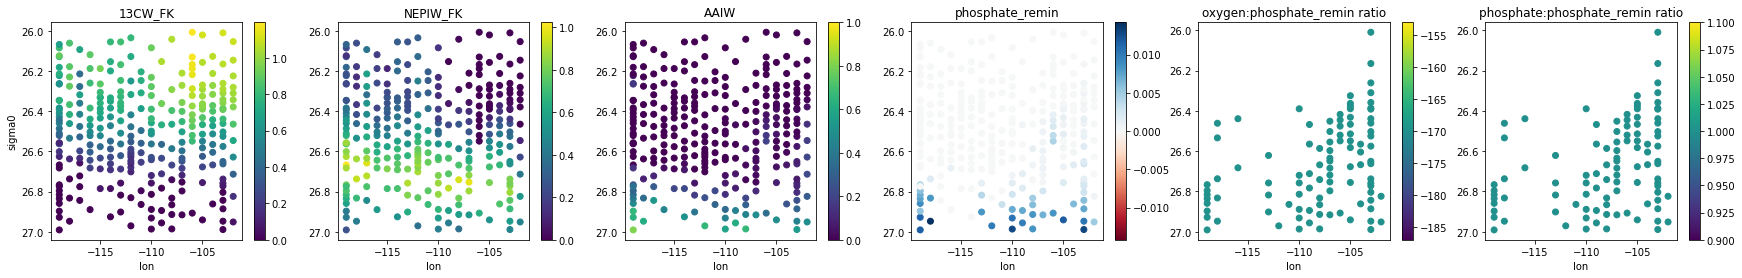

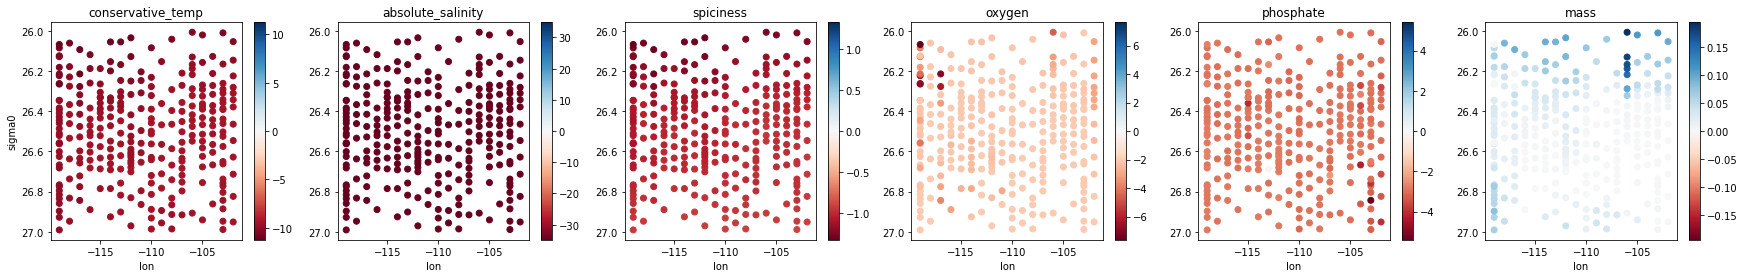

evansorig_settings_nospiciness


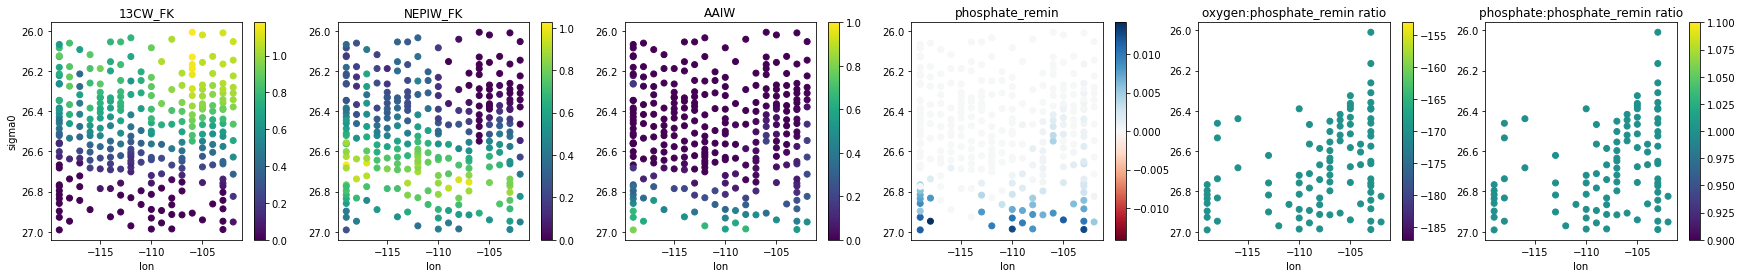

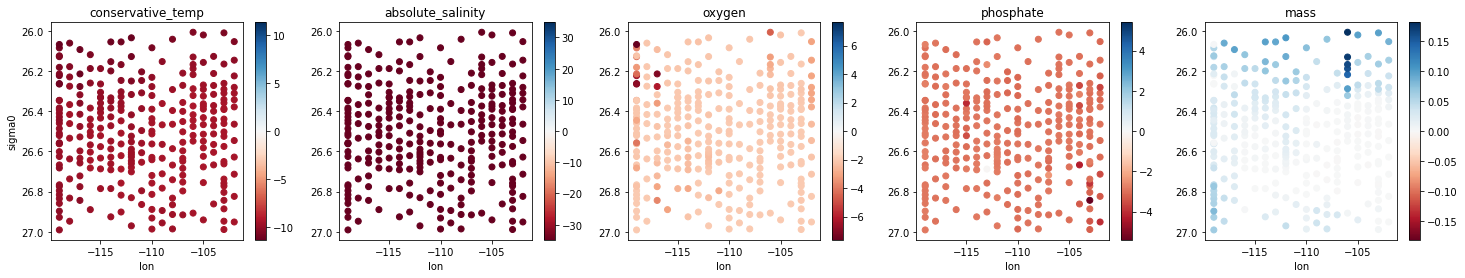

evansorig_settings_nospiciness_hardmassconstraint


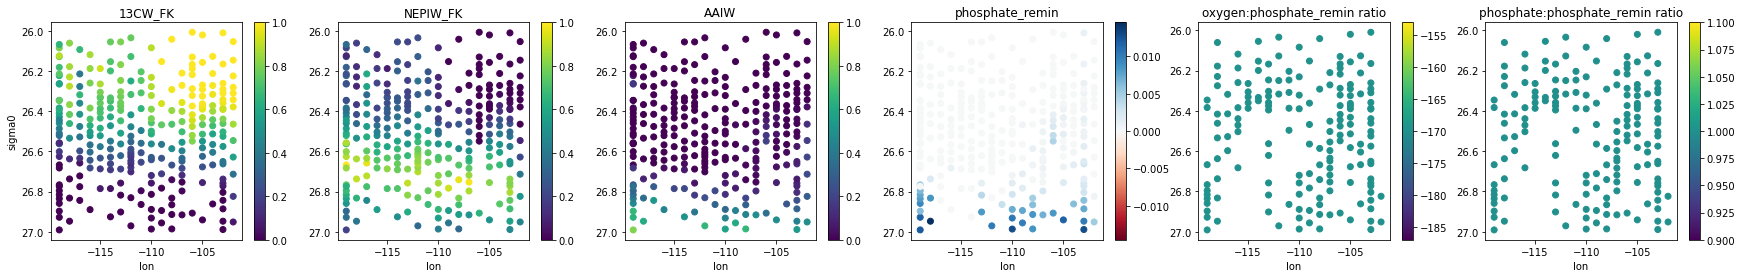

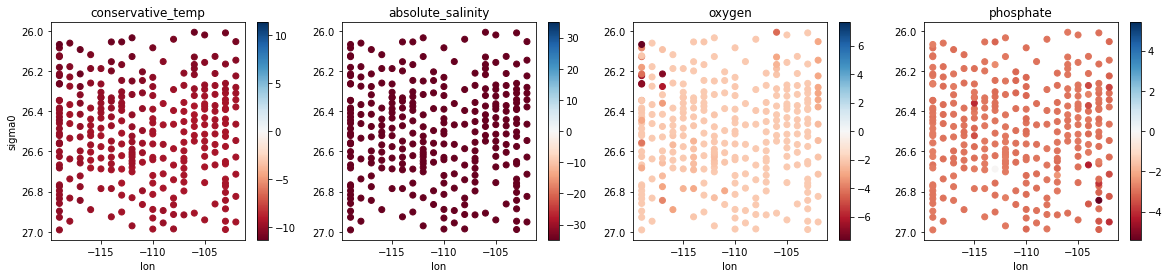

evansorig_settings_nospiciness_hardmassconstraint_assimpossible


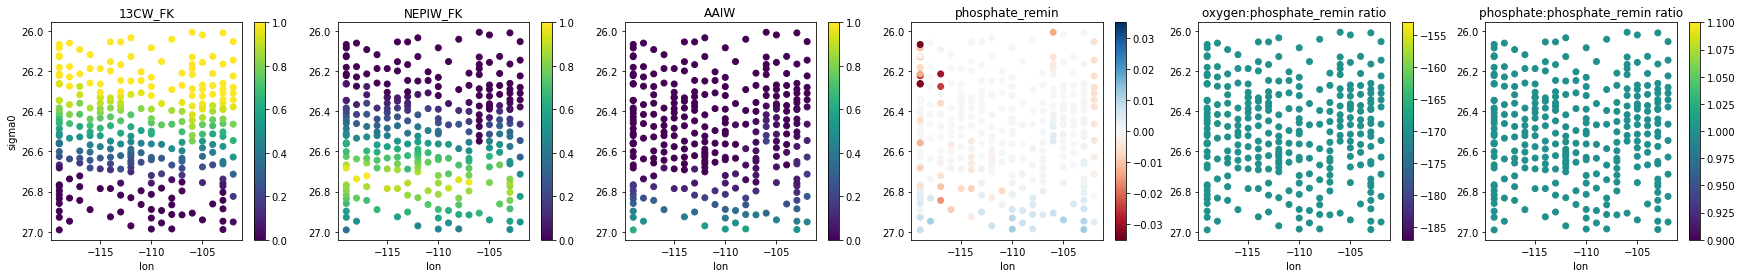

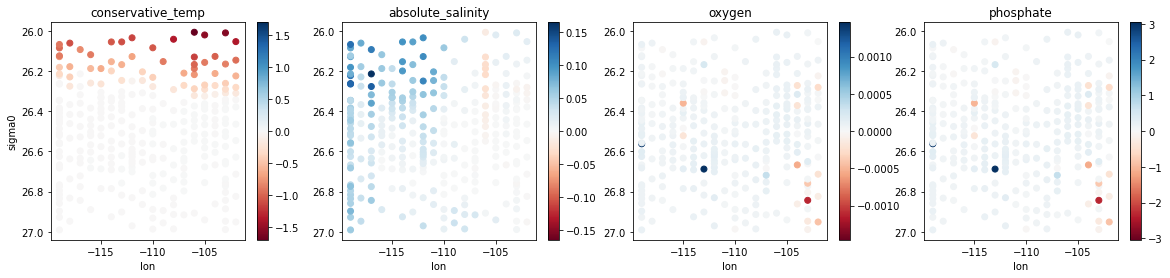

Falkor with PSUW
evansorig_settings_nospiciness_hardmassconstraint_withpsuw


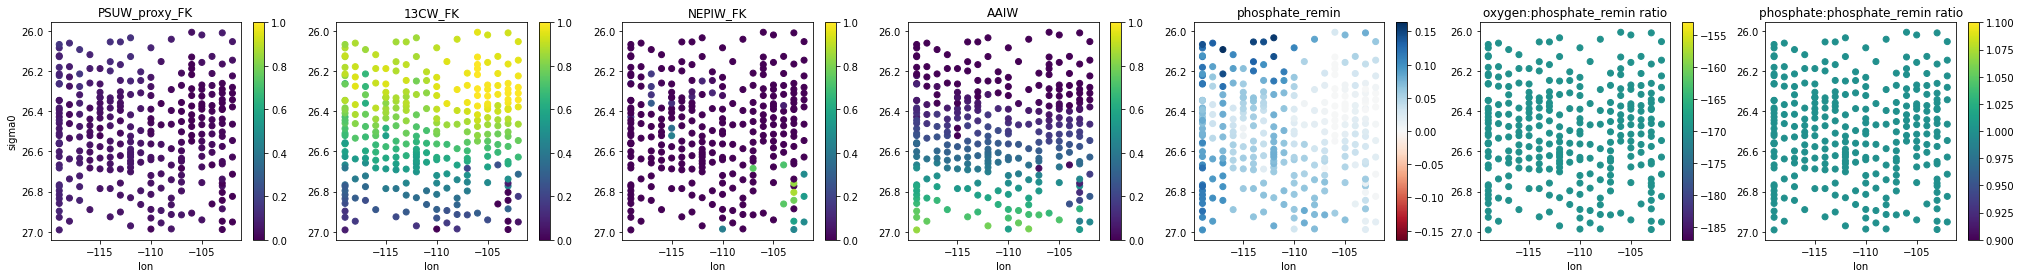

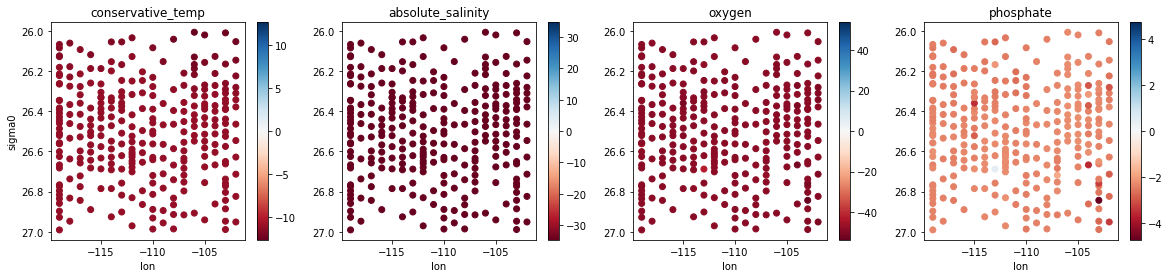

RR
evansorig_settings


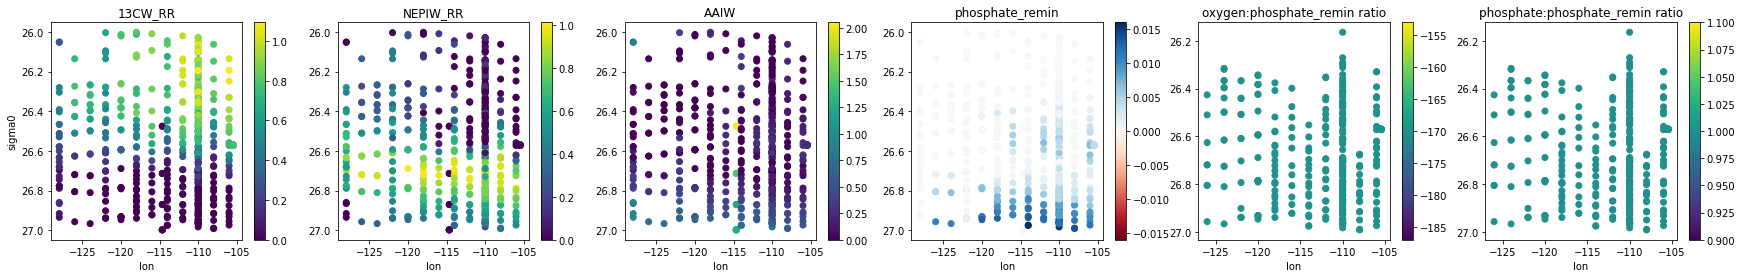

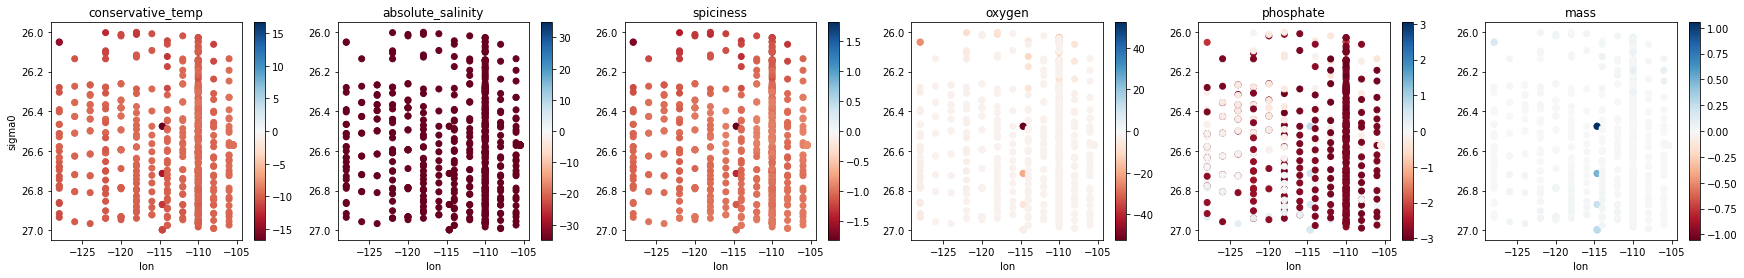

evansorig_settings_nospiciness


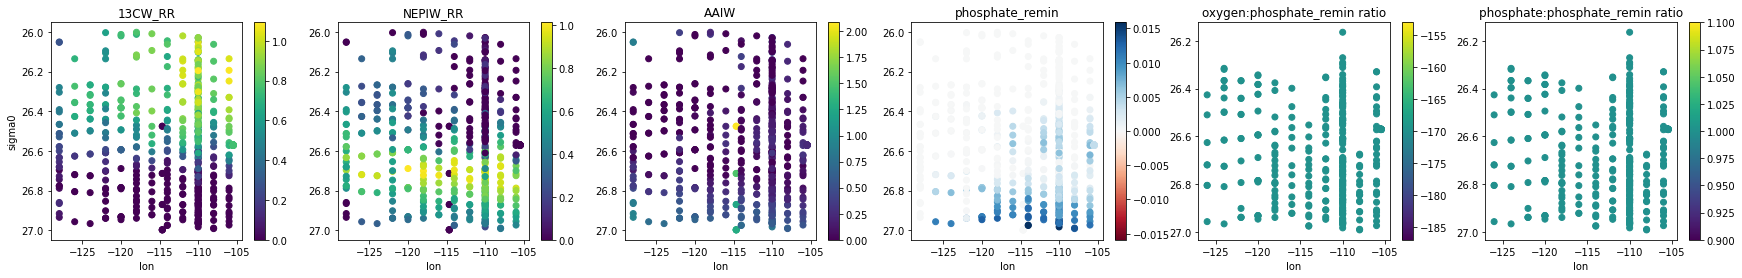

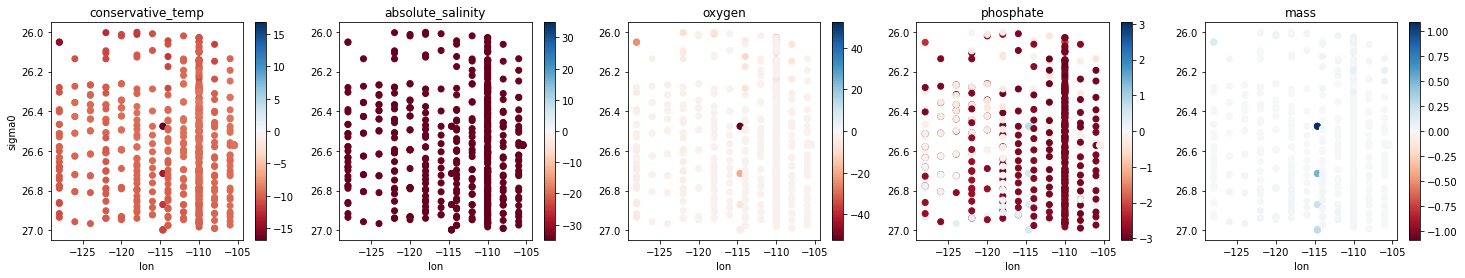

evansorig_settings_nospiciness_hardmassconstraint


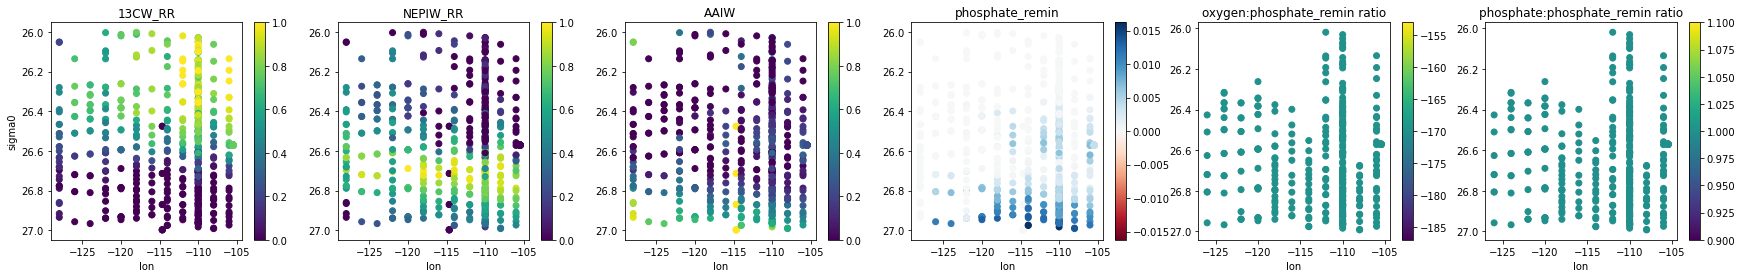

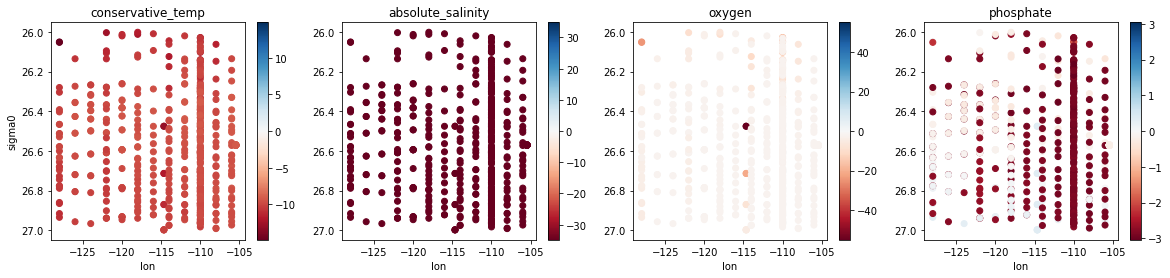

evansorig_settings_nospiciness_hardmassconstraint_assimpossible


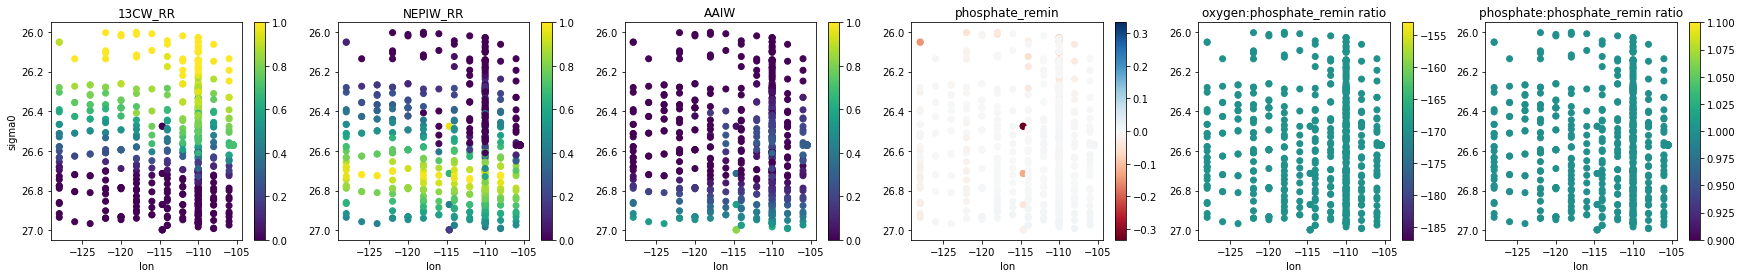

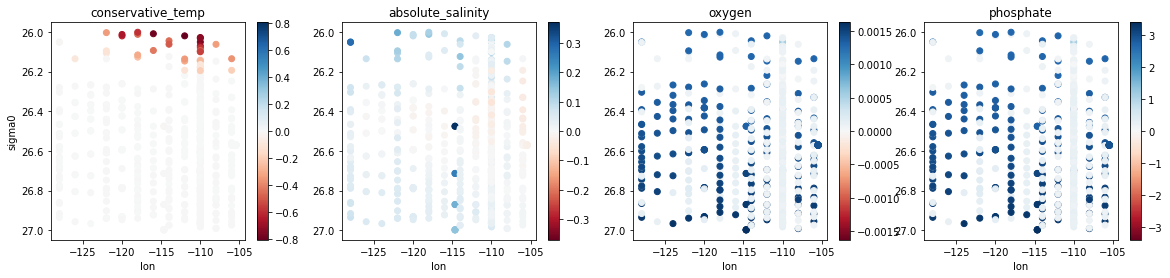

RR with PSUW
evansorig_settings_nospiciness_hardmassconstraint_withpsuw


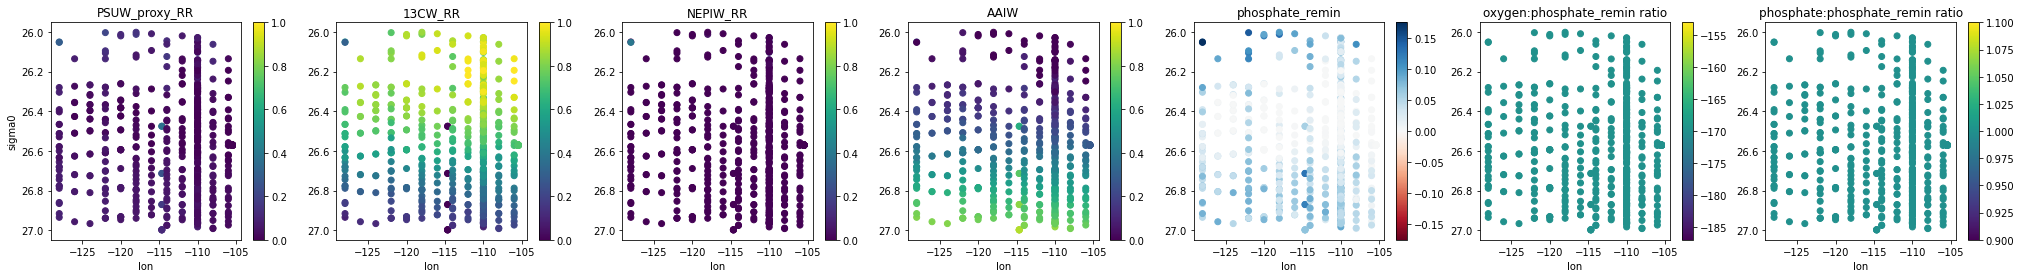

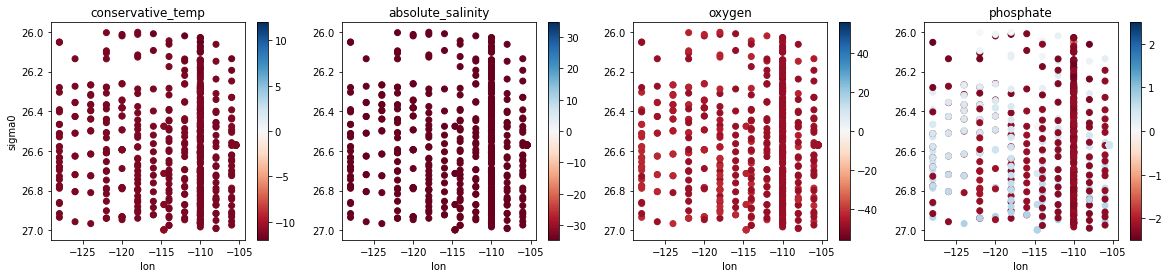

Falkor surface
evansorig_settings


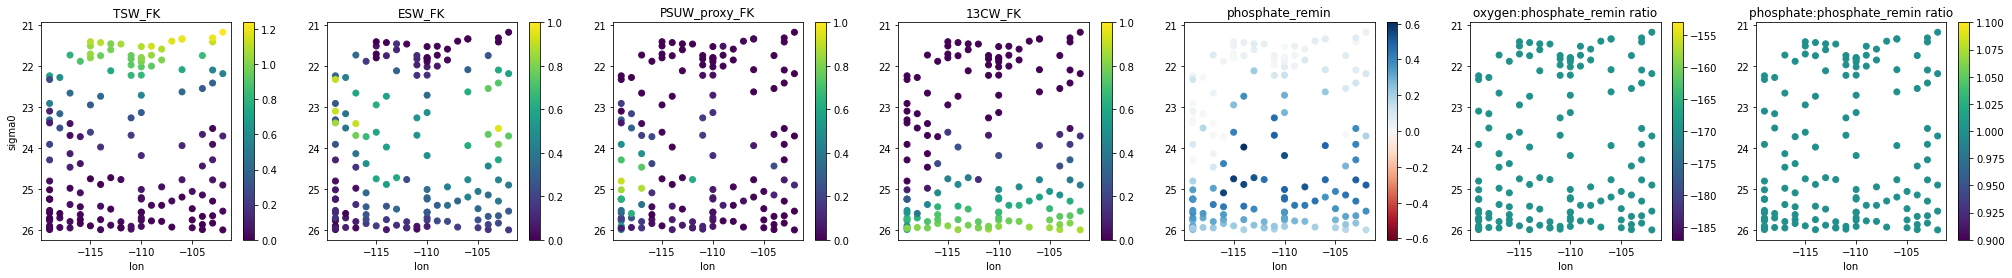

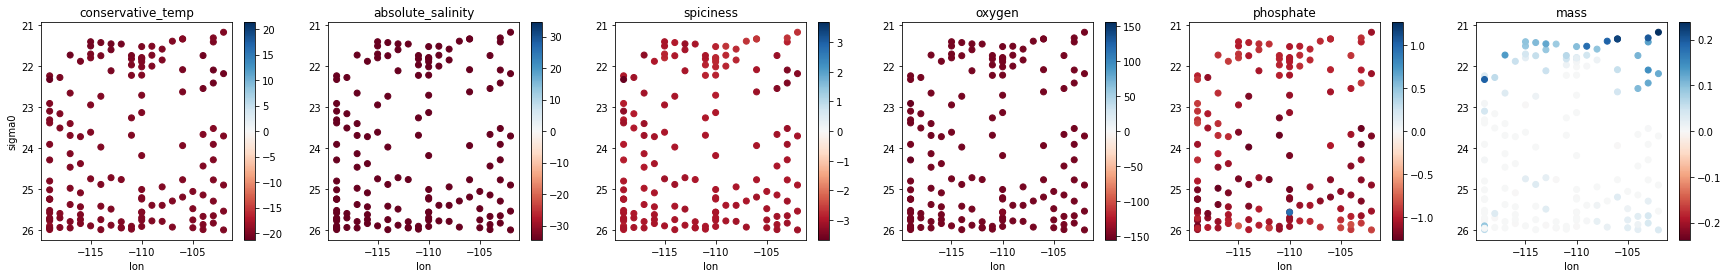

evansorig_settings_nospiciness


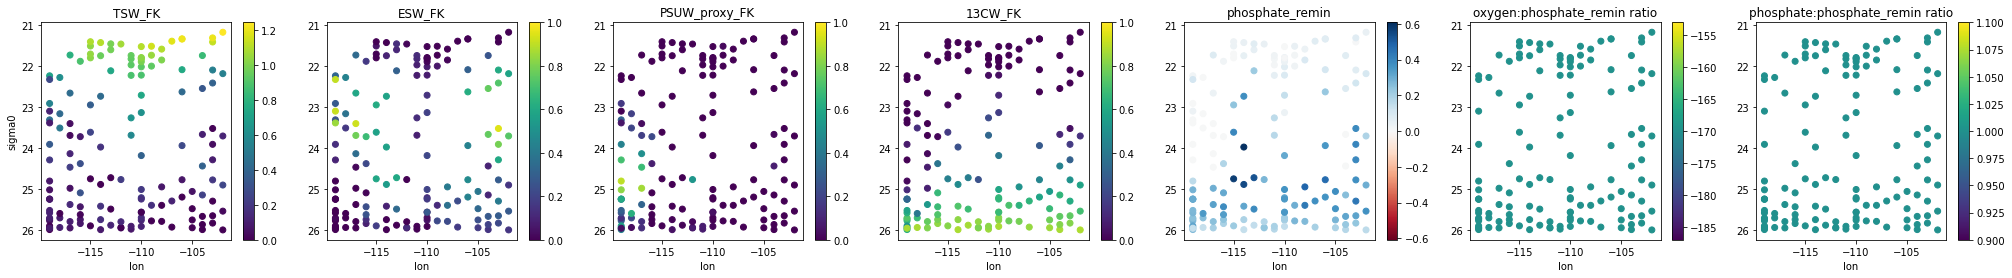

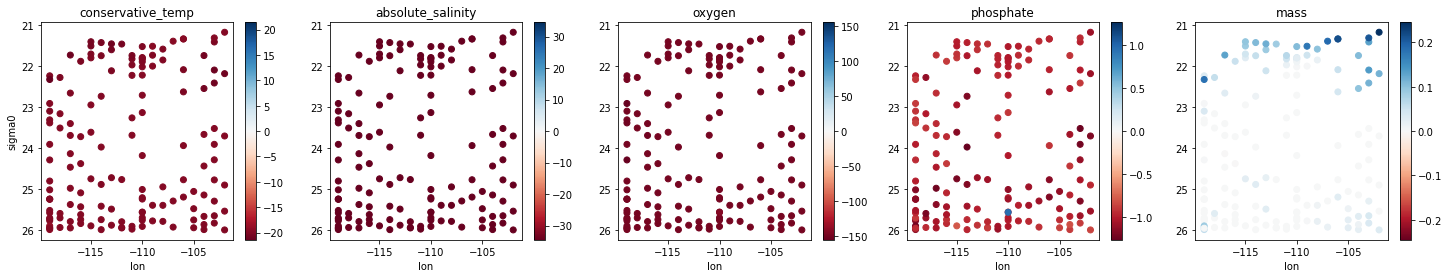

evansorig_settings_nospiciness_hardmassconstraint


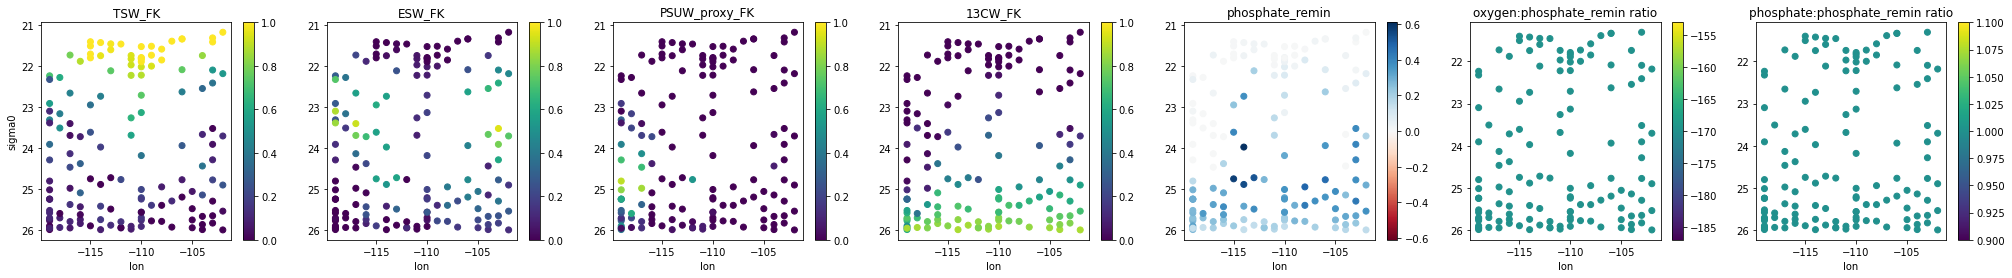

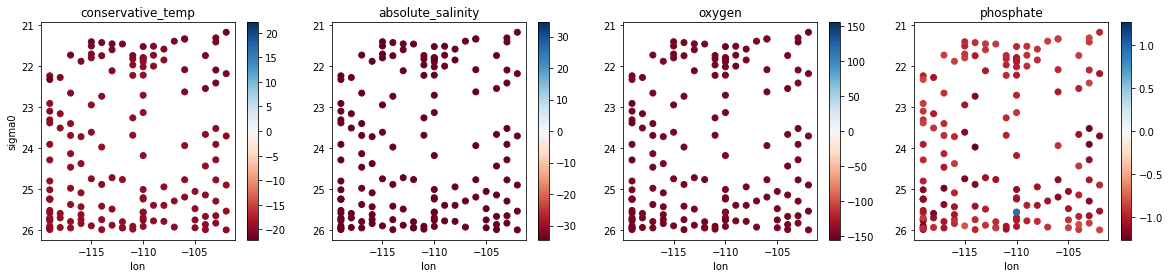

evansorig_settings_nospiciness_hardmassconstraint_assimpossible


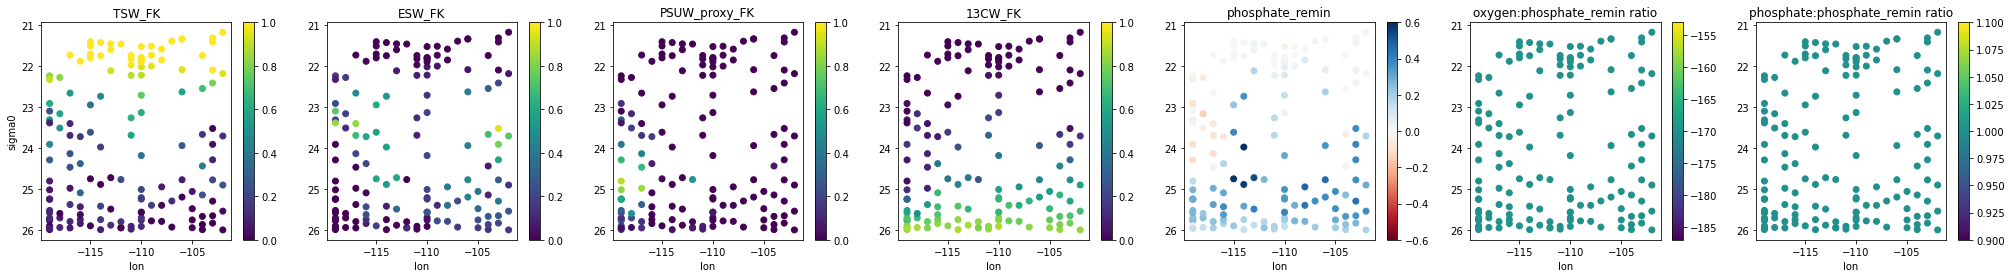

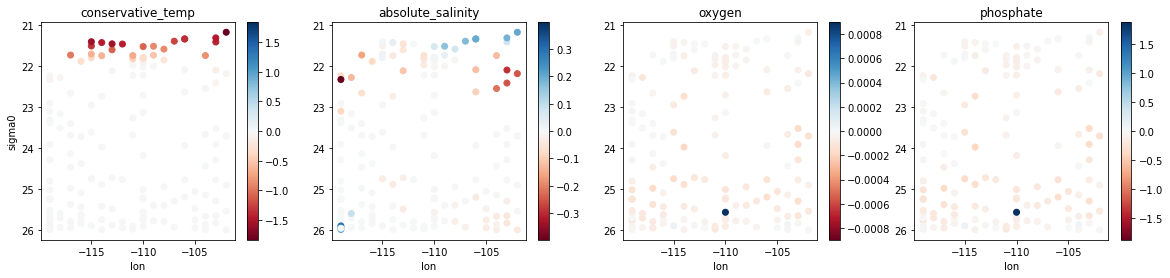

In [16]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "sigma0"

print("Falkor")
for settingname in settingname_to_fkintermediatesoln:
    print(settingname)
    ompa_soln = settingname_to_fkintermediatesoln[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname=yaxis_colname)
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname=yaxis_colname)
    
print("Falkor with PSUW")
for settingname in settingname_to_fkintermediatesoln_withpsuw:
    print(settingname)
    ompa_soln = settingname_to_fkintermediatesoln_withpsuw[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname=yaxis_colname)
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname=yaxis_colname)
    
print("RR")
for settingname in settingname_to_rrintermediatesoln:
    print(settingname)
    ompa_soln = settingname_to_rrintermediatesoln[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname=yaxis_colname)
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname=yaxis_colname)
    

    
print("RR with PSUW")
for settingname in settingname_to_rrintermediatesoln_withpsuw:
    print(settingname)
    ompa_soln = settingname_to_rrintermediatesoln_withpsuw[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname=yaxis_colname)
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname=yaxis_colname)

print("Falkor surface")
for settingname in settingname_to_surfaceompasoln:
    print(settingname)
    ompa_soln = settingname_to_surfaceompasoln[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lon",
                                      yaxis_colname=yaxis_colname)
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lon",
                            yaxis_colname=yaxis_colname)

In [17]:
!pwd

/Users/avantishrikumar/Research/pyompa/examples
